# This Notebook estimates the model

## Settings

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from time import time
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from figure_manager import FigureManager
from plots import *

import DynamicTimeAllocationModel

path = 'output/'

fm = FigureManager(path, use_latex=False)

# c++ settings
do_compile = True
threads = 40

# from EconModel import cpptools
# cpptools.setup_nlopt(folder='cppfuncs/', do_print=True)

In [2]:
# setup model
settings = { 
       'T':30,
       'num_A': 16,
       'num_A_pd': 32,
       'num_K': 12,
       'num_power': 9,
       'num_love': 5,
       'num_types': 4,
       
       'max_A': 1_000,
       'max_A_pd': 1_000,
       'max_Ctot': 2_000,
       'max_K': 50,
       
       'init_couple_share': 0.77,
       
       'simT': 30,
       'simN': 10_000,

       'num_Ctot': 1024,
       'num_marg_u':1024,
       
       'beta': 0.98,
       'R': 1.03,
       'rho': 1.5,
       
       'phi': 1.0,
       'phi_mult': 1.0,
       
       'mu': 2.5,
       'mu_mult': 1.0,
       
       'gamma': 0.14,
       'gamma_mult': 1.0,
       
       'gamma2': 0.00,
       'gamma2_mult': 1.0,
       
       'sigma_mu': 0.1,
       'sigma_mu_mult': 1.0,
       
       'p_meet': 0.0,

       'threads':threads,
       'num_multistart': 2,
       
       'do_egm': True,
       'interp_method': 'linear',
       'interp_inverse': True,
       
       'precompute_intratemporal': True,
       'centered_gradient': True,
       }

model = DynamicTimeAllocationModel.HouseholdModelClass(par=settings) 
model.link_to_cpp(force_compile=do_compile)

## Empirical Moments to Match

In [3]:
# all moments listed here will be used in estimation. Comment out those you do not want to use.
datamoms = dict()

# wages
datamoms['wage_level_w_25_34'] = 40.1
datamoms['wage_level_m_25_34'] = 49.3
datamoms['wage_level_w_35_44'] = 50.4
datamoms['wage_level_m_35_44'] = 67.8

# employment rates
datamoms['employment_rate_w_35_44'] = 70.0 #64.0
datamoms['employment_rate_m_35_44'] = 85.0 #88.0
datamoms['work_hours_w'] = 1674.0 / 52.0  # annual hours to weekly hours
datamoms['work_hours_m'] = 2062.0 / 52.0  # annual hours to weekly hours

# # home production
# datamoms['home_prod_w'] = 1535.0
# datamoms['home_prod_m'] = 1035.0

# # consumption
datamoms['consumption'] = 42.716

# # marriage and divorce rates
# datamoms['marriage_rate_35_44'] = 69.0
# datamoms['divorce_rate_35_44'] = 12.0

# Mazzocco moments
datamoms['leisure_w'] = 60.0
datamoms['leisure_m'] = 61.0
datamoms['home_prod_w'] = 25.2
datamoms['home_prod_m'] = 12.3


# weights
weights = dict()
for mom in ('work_hours_w', 'work_hours_m', 'home_prod_w', 'home_prod_m'):
    pass
    # weights[mom] = 0.01


## Parameters to estimate

In [ ]:
# parameters to estimate
estpars = {
    # Wages
    # 'mu': {'guess':3.5172,'lower':1.8,'upper':3.00}, 
    # 'mu_mult': {'guess':1.0533,'lower':1.0,'upper':2.5},
    # 'gamma': {'guess':0.0677,'lower':0.01,'upper':0.20},
    # 'gamma_mult': {'guess':1.1857,'lower':1.0,'upper':2.5},
    # 'gamma2': {'guess':-0.0010,'lower':-0.002,'upper':0.0},
    # 'gamma2_mult': {'guess':1.1857,'lower':0.5,'upper':2.5},
    
    # 'sigma_mu': {'guess':0.1,'lower':0.01,'upper':1.0},
    # 'sigma_mu_mult': {'guess':1.0,'lower':0.5,'upper':2.0},
    
    # 'rho': {'guess':1.5,'lower':1.0,'upper':3.0},
    
    # Disutility from work
    # 'eta': {'guess':0.5211,'lower':1.1,'upper':4.0},
    # 'eta_mult': {'guess':1.0,'lower':0.5,'upper':3.0},
    # 'phi': {'guess':0.7,'lower':0.1,'upper':4.0},
    # 'phi_mult': {'guess':1.0,'lower':0.5,'upper':3.0},
    
    # Home production
    # 'alpha': {'guess':1.0,'lower':0.9,'upper':1.9},
    # 'zeta': {'guess':0.5,'lower':0.1,'upper':2.0},
    # 'omega': {'guess':0.5,'lower':0.1,'upper':2.0},
    # 'pi': {'guess':0.5,'lower':0.1,'upper':0.9},
    # 'lambda_': {'guess':0.5,'lower':5.0,'upper':20.0},
    
    # 'tax_rate': {'guess':0.25,'lower':0.15,'upper':0.5},
    # 'available_hours': {'guess':1.0,'lower':1.0,'upper':5000.0},
    # 'full_time_hours': {'guess':0.35,'lower':0.01,'upper':1.0},
    
    'sigma_k': {'guess':0.05,'lower':0.01,'upper':0.5},
    'phi_k': {'guess':0.4,'lower':0.1,'upper':0.9},
    
    # # Match quality
    # 'sigma_love': {'guess':0.15,'lower':0.01,'upper':20.5},
    # 'div_cost': {'guess':0.0,'lower':0.0,'upper':100.0},
}


# set parameters to these values if not estimated
use_fixed_init = True # overwrites initial guesses in estpars if True
fixed = {
    'mu': 2.3124, 
    'mu_mult': 1.1465,
    'gamma': 0.0203,
    'gamma_mult': 1.40,
    'gamma2': -0.0012,
    'gamma2_mult': 1.1373,
    
    'rho': 1.5,
    
    'sigma_mu': 0.5250,
    'sigma_mu_mult': 1.0,
    
    'sigma_K': 0.07,
    
    'eta'            : 2.85,
    'eta_mult'       : 1.0,
    'phi'            : 1.97,
    'phi_mult'       : 1.0,

    'alpha'          : 1.18,
    'zeta'           : 0.40,
    'omega'          : 0.38,
    'pi'             : 0.6534,
    
    'lambda_'        : 7.2144,
    
    'phi_k'          : 0.4,
    
    'tax_rate'       : 0.0,
    'available_hours': 1.0,
    'full_time_hours': 0.36,
    
    'sigma_love': 8.0,
    'div_cost': 0.0,
}

# equal
# fixed = {
#     'mu': 3.5172, 
#     'mu_mult': 1.0,
#     'gamma': 0.0677,
#     'gamma_mult': 1.0,
    
#     'eta'            : 2.85,
#     'eta_mult'       : 1.0,
#     'phi'            : 1.97,
#     'phi_mult'       : 1.0,

#     'alpha'          : 1.0,#too much specialization with these wage differences
#     'zeta'           : 0.40,
#     'omega'          : 0.38,
#     'pi'             : 0.5,
    
#     'lambda_'        : 10.0,
    
#     'sigma_love': 0.15,
#     'div_cost': 0.0,
# }

# Mazzocco et al:
# fixed = {
#     'mu': 3.5172, 
#     'mu_mult': 1.0533,
#     'gamma': 0.0677,
#     'gamma_mult': 1.1857,
    
#     'eta'            : 2.85,
#     'eta_mult'       : 1.0,
#     'phi'            : 1.97,
#     'phi_mult'       : 1.0,

#     'alpha'          : 1.18,
#     'zeta'           : 0.40,
#     'omega'          : 0.38,
#     'pi'             : 0.5,
    
#     'lambda_'        : 10.0,
    
#     'sigma_love': 0.15,
#     'div_cost': 0.0,
# }


## setup initial guess 

In [5]:
# set fixed parameters and potentially update initial values
for key in fixed.keys():
    if key not in estpars.keys():
        setattr(model.par,key,fixed[key])
    
    else:
        if use_fixed_init:
            estpars[key]['guess'] = fixed[key]
        

In [6]:
# check bounds
bounds_ok = True
for key in estpars.keys():
    if estpars[key]['guess']<estpars[key]['lower']:
        print(key,' lower',estpars[key]['guess'])
        bounds_ok = False
    
    if estpars[key]['guess']>estpars[key]['upper']:
        print(key,' upper',estpars[key]['guess'])
        bounds_ok = False

if not bounds_ok:
    stop

In [7]:
model.par.grid_mu_w

array([2.26655858, 2.42580362, 2.57419638, 2.73344142])

In [8]:
# check initial guess
theta_init = np.array([estpars[key]['guess'] for key in estpars.keys()])
obj_init = model.obj_func(theta_init, estpars, datamoms, weights, do_print=True)

Parameters:
  sigma_k        : 0.0500 (init: 0.0500)
  phi_k          : 0.4000 (init: 0.4000)
Moments:
  wage_level_w_25_34       : sim: 41.4638, data: 40.1000
  wage_level_m_25_34       : sim: 52.1506, data: 49.3000
  wage_level_w_35_44       : sim: 52.9383, data: 50.4000
  wage_level_m_35_44       : sim: 69.2500, data: 67.8000
  employment_rate_w_35_44  : sim: 70.5896, data: 70.0000
  employment_rate_m_35_44  : sim: 97.6629, data: 85.0000
  work_hours_w             : sim: 40.2027, data: 32.1923
  work_hours_m             : sim: 40.3195, data: 39.6538
  consumption              : sim: 36.3337, data: 42.7160
  leisure_w                : sim: 58.2178, data: 60.0000
  leisure_m                : sim: 58.6975, data: 61.0000
  home_prod_w              : sim: 23.0598, data: 25.2000
  home_prod_m              : sim: 14.1408, data: 12.3000
Objective function value: 518.4429 (penalty: 0.0000, 217.4241)
-------------------------------------


In [9]:
model.par.grid_mu_w

array([1.08683254, 1.92286901, 2.70193099, 3.53796746])

check that solution makes sense

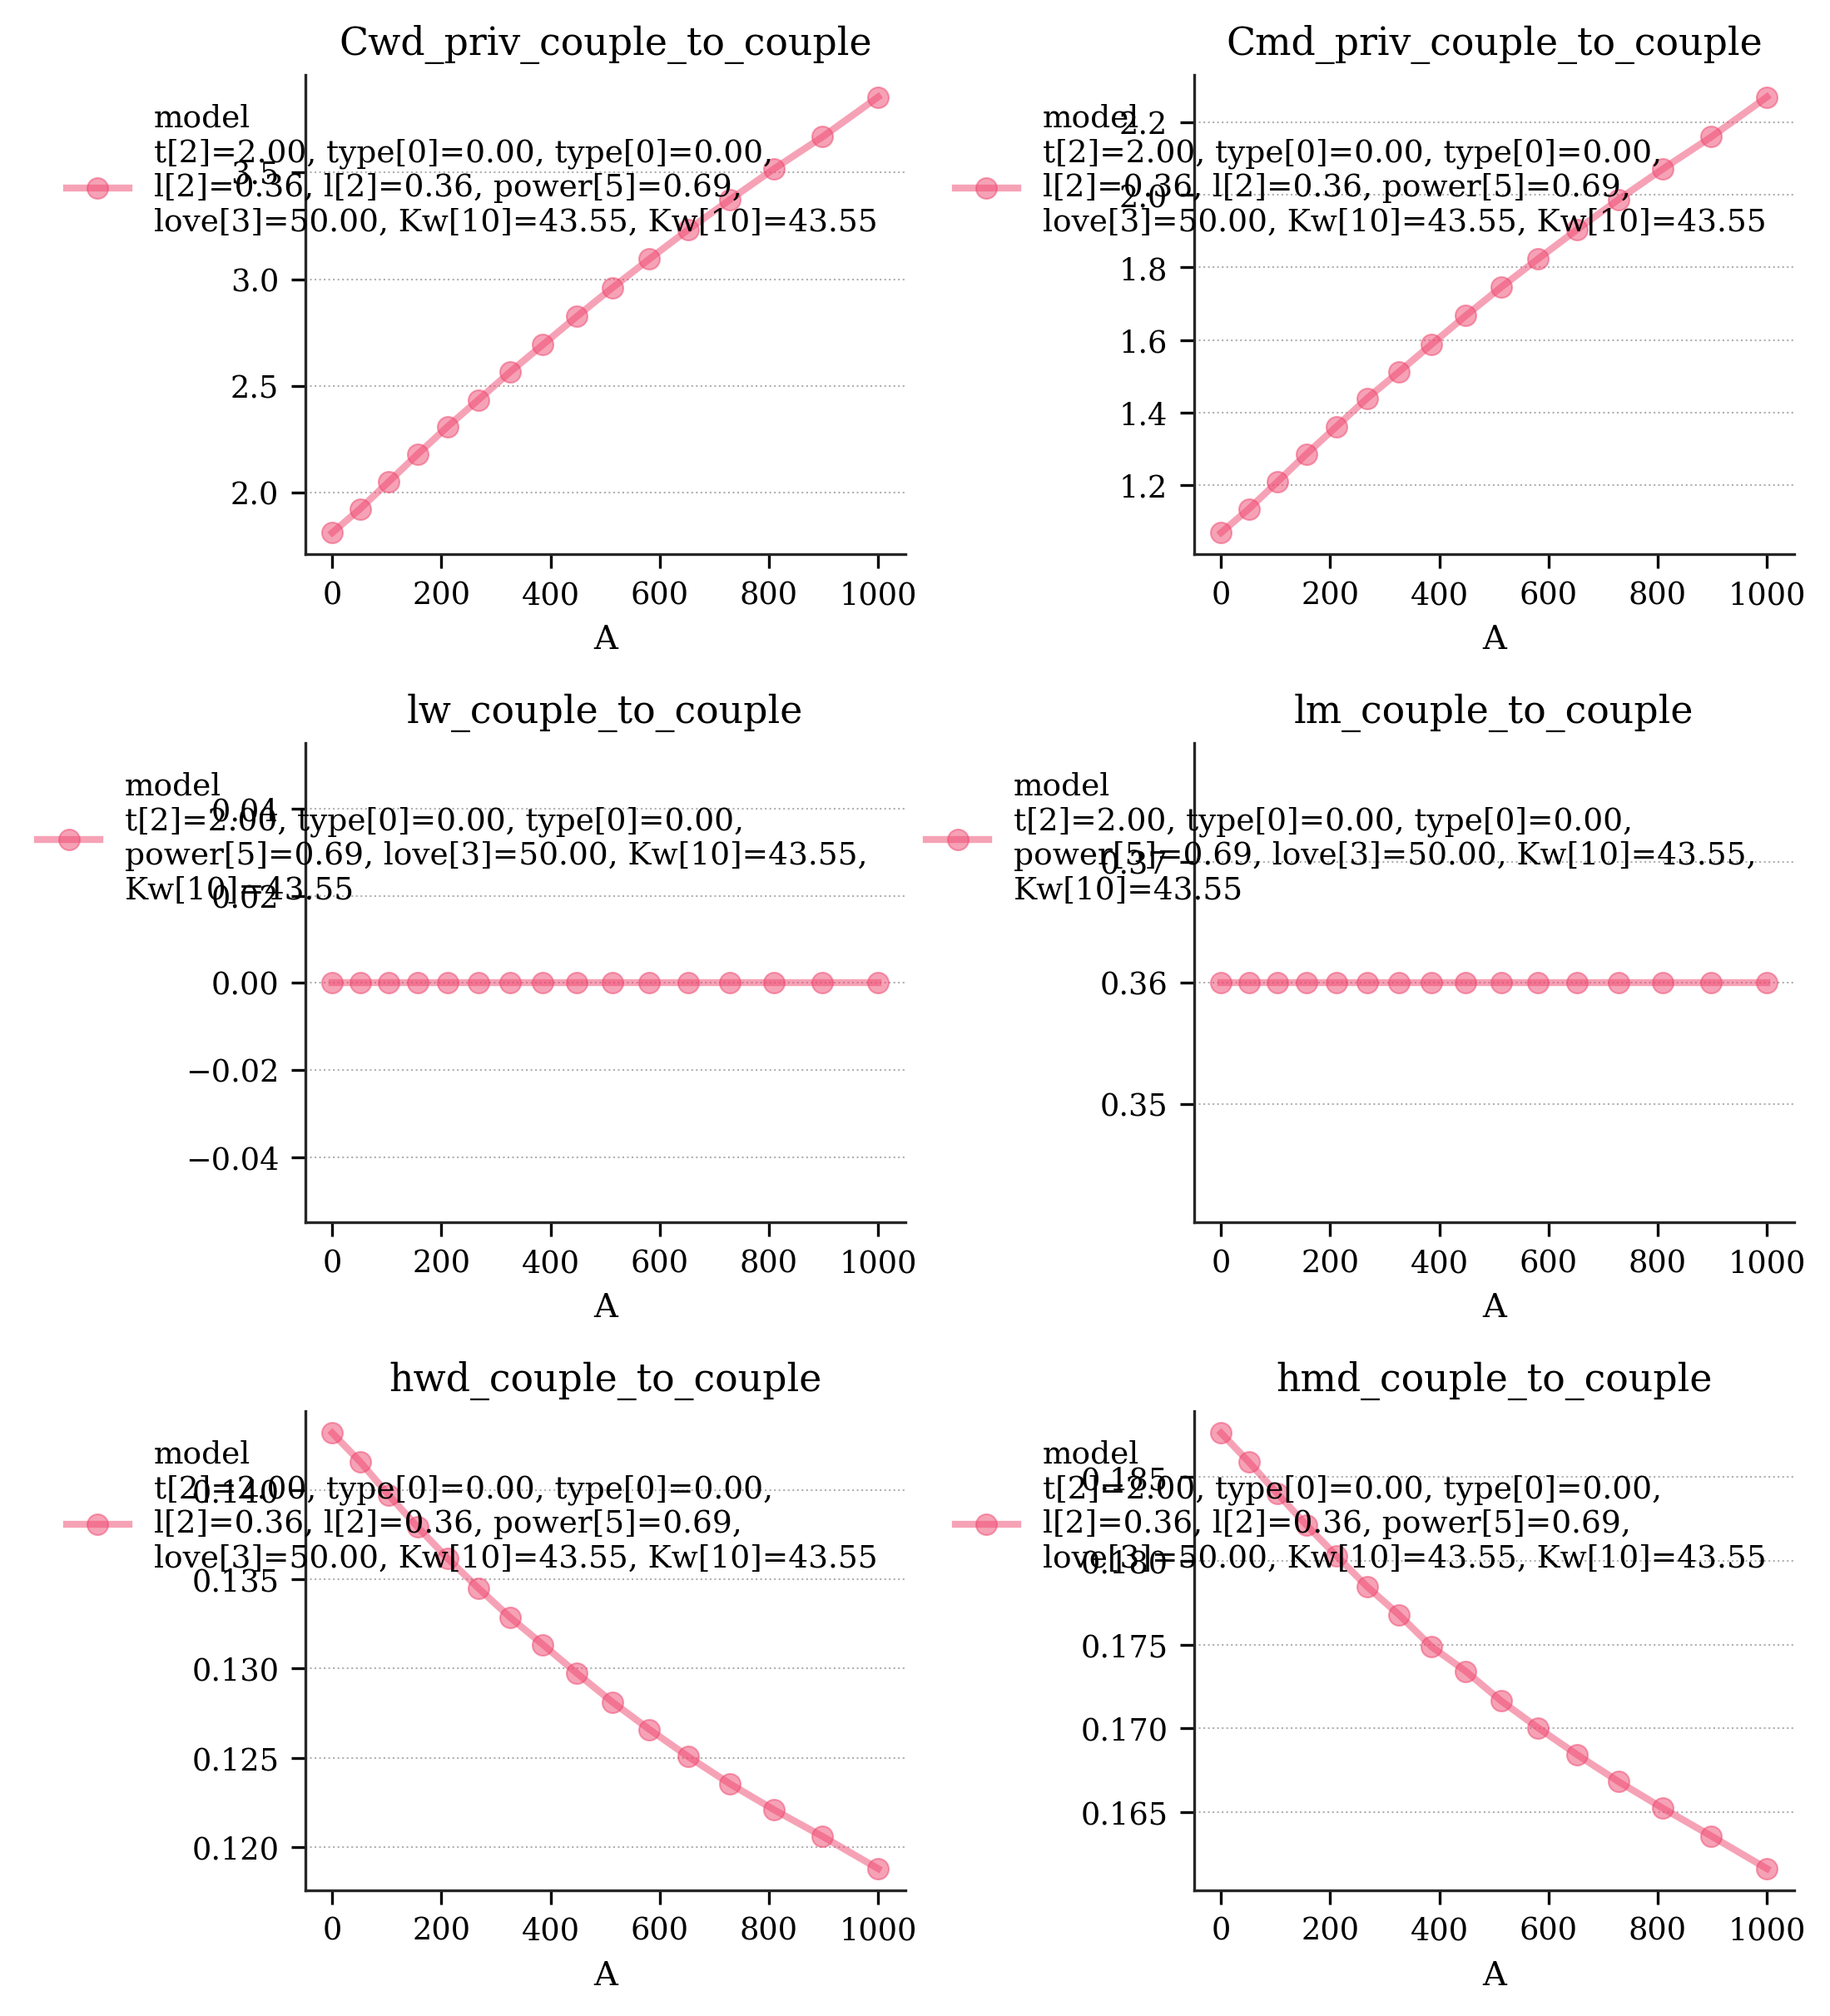

In [10]:
from plots import *

grid = 'grid_A'
idx = {'t': 2, 'il':2, 'type': 0, 'iK': 10, 'iP': 5, 'iL': 3, 'iA': 10, 'iA_pd': 10}

mp = model_plotter(model, model_name='model', titles=['variable'], labels=['model', 'index'])
fig, ax = fm.create_figure(3,2,6)
mp.plot_gender_couple_choices(ax, grid=grid, index=idx, alpha=0.5)
fig.tight_layout()

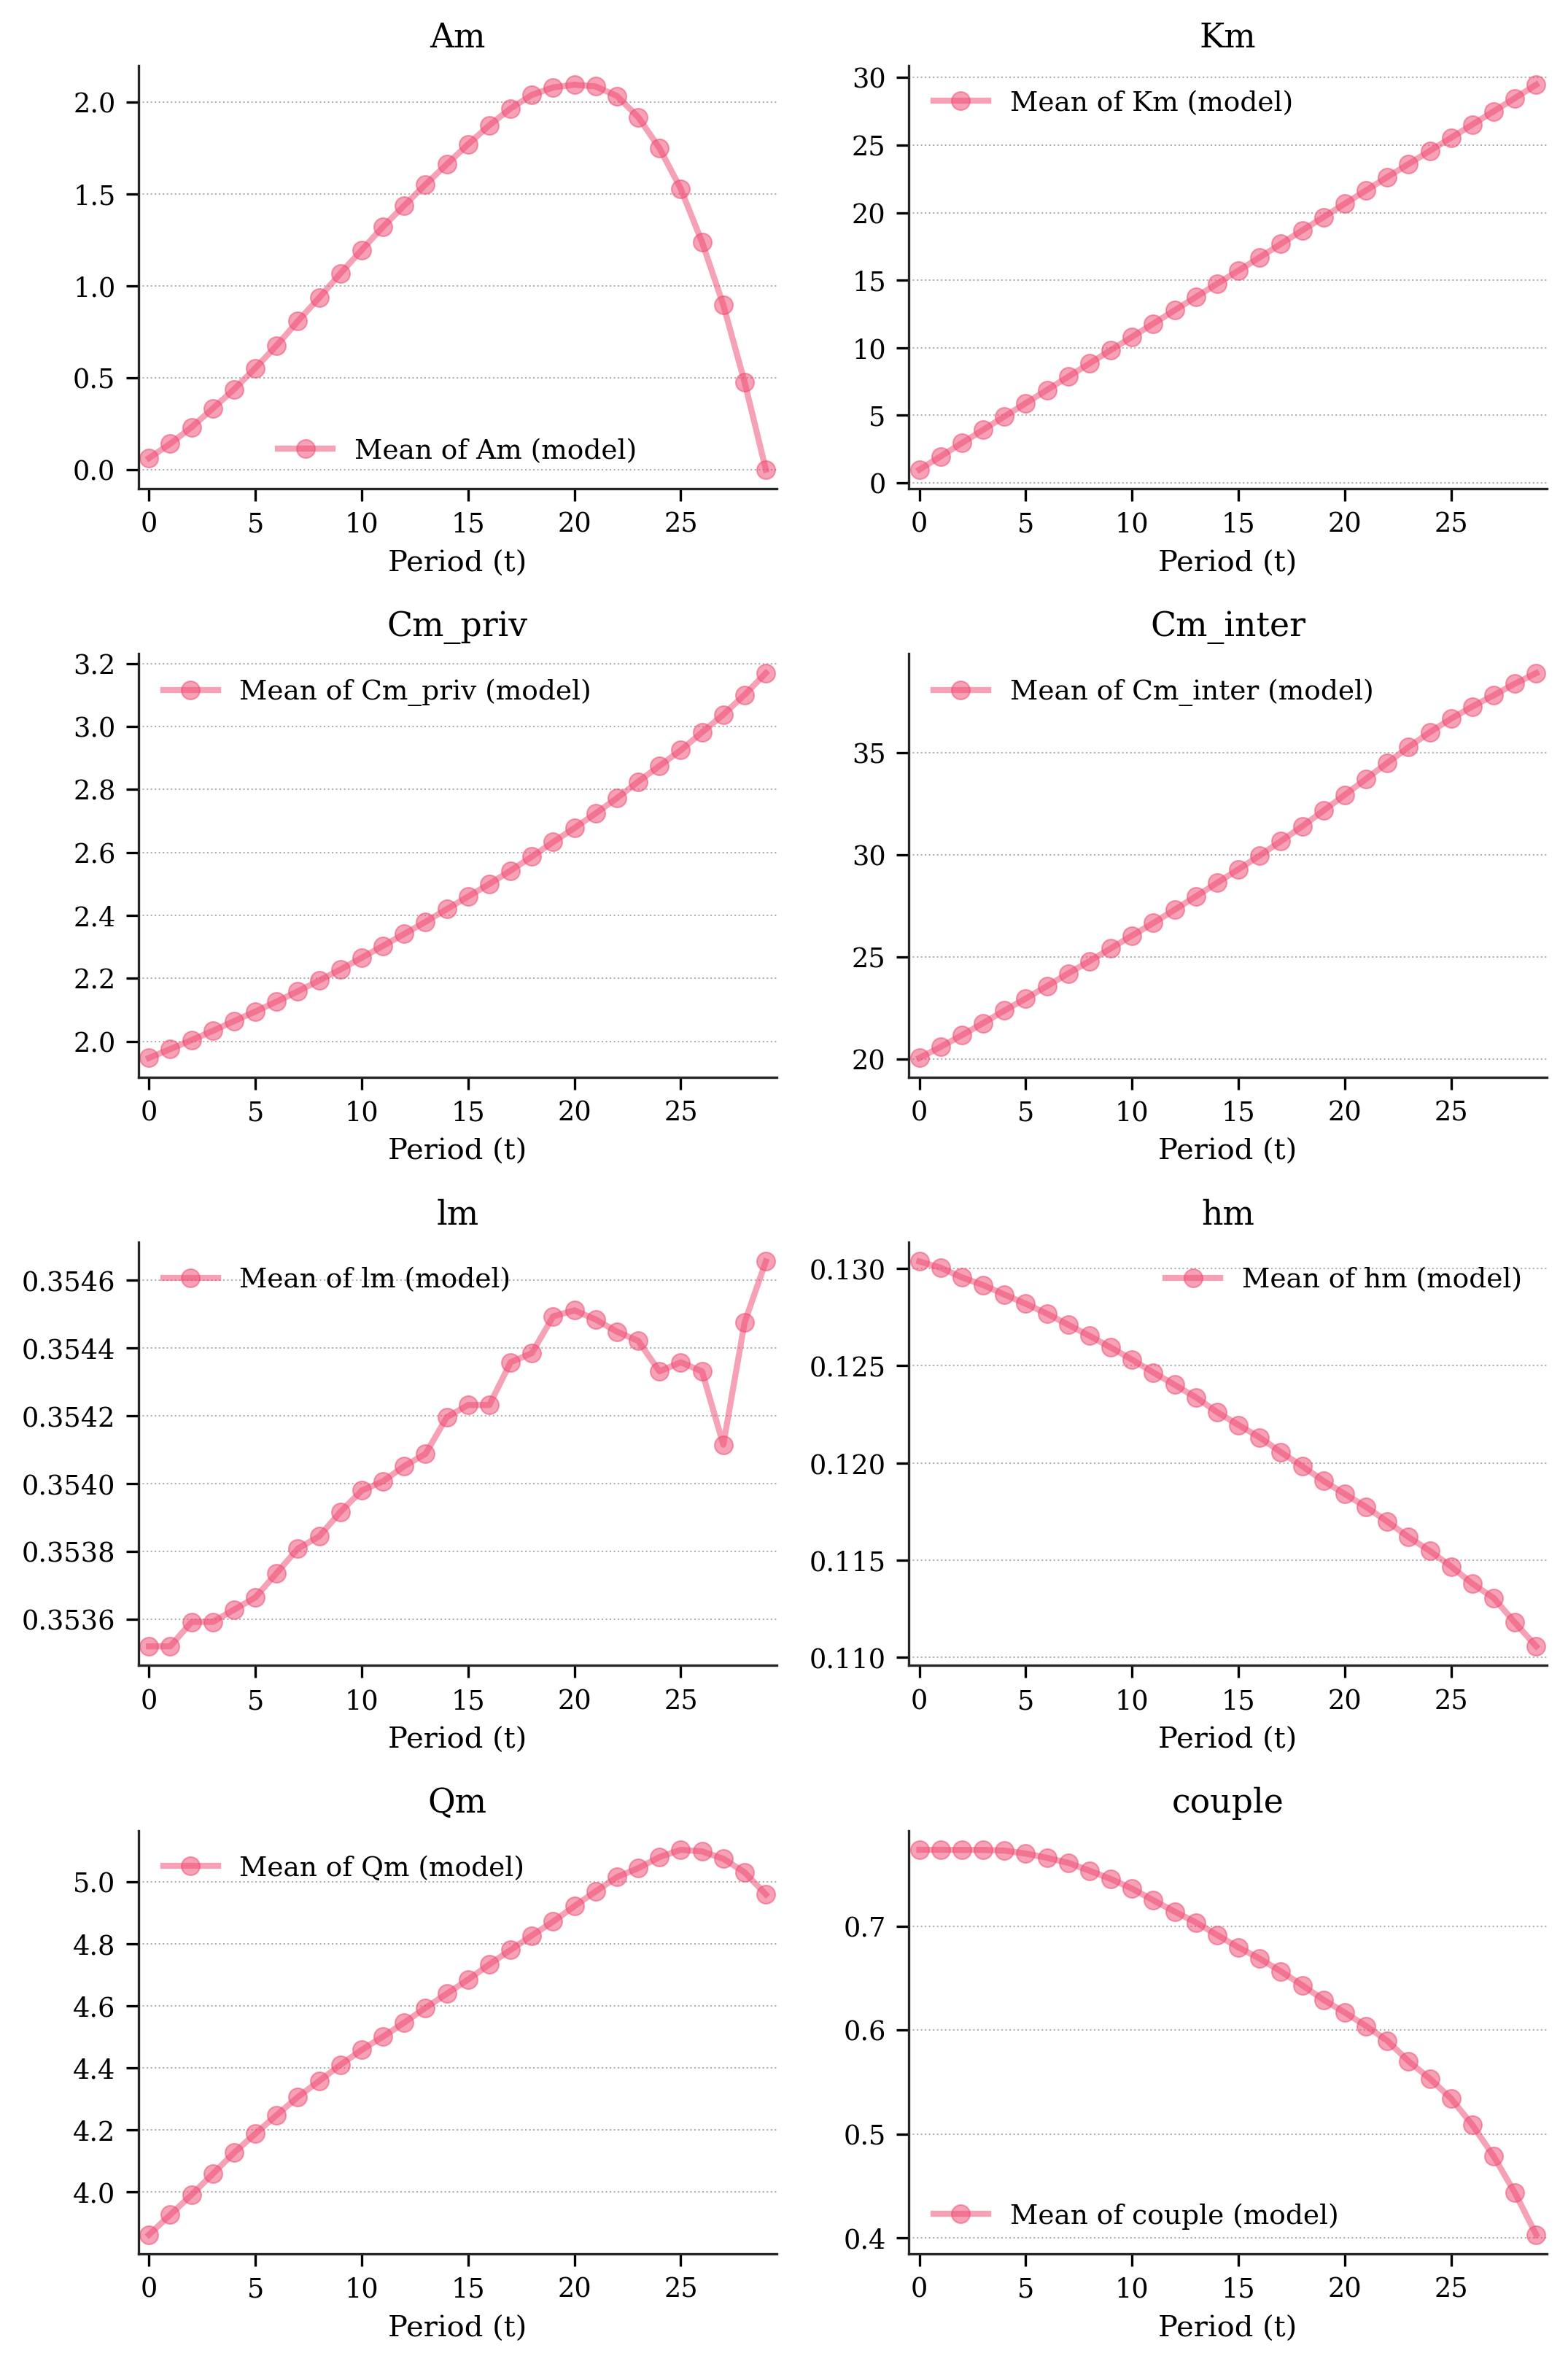

In [11]:
fig, ax = fm.create_figure(4,2,8)
mp.plot_sim_male(ax, alpha=0.5)
fig.tight_layout()

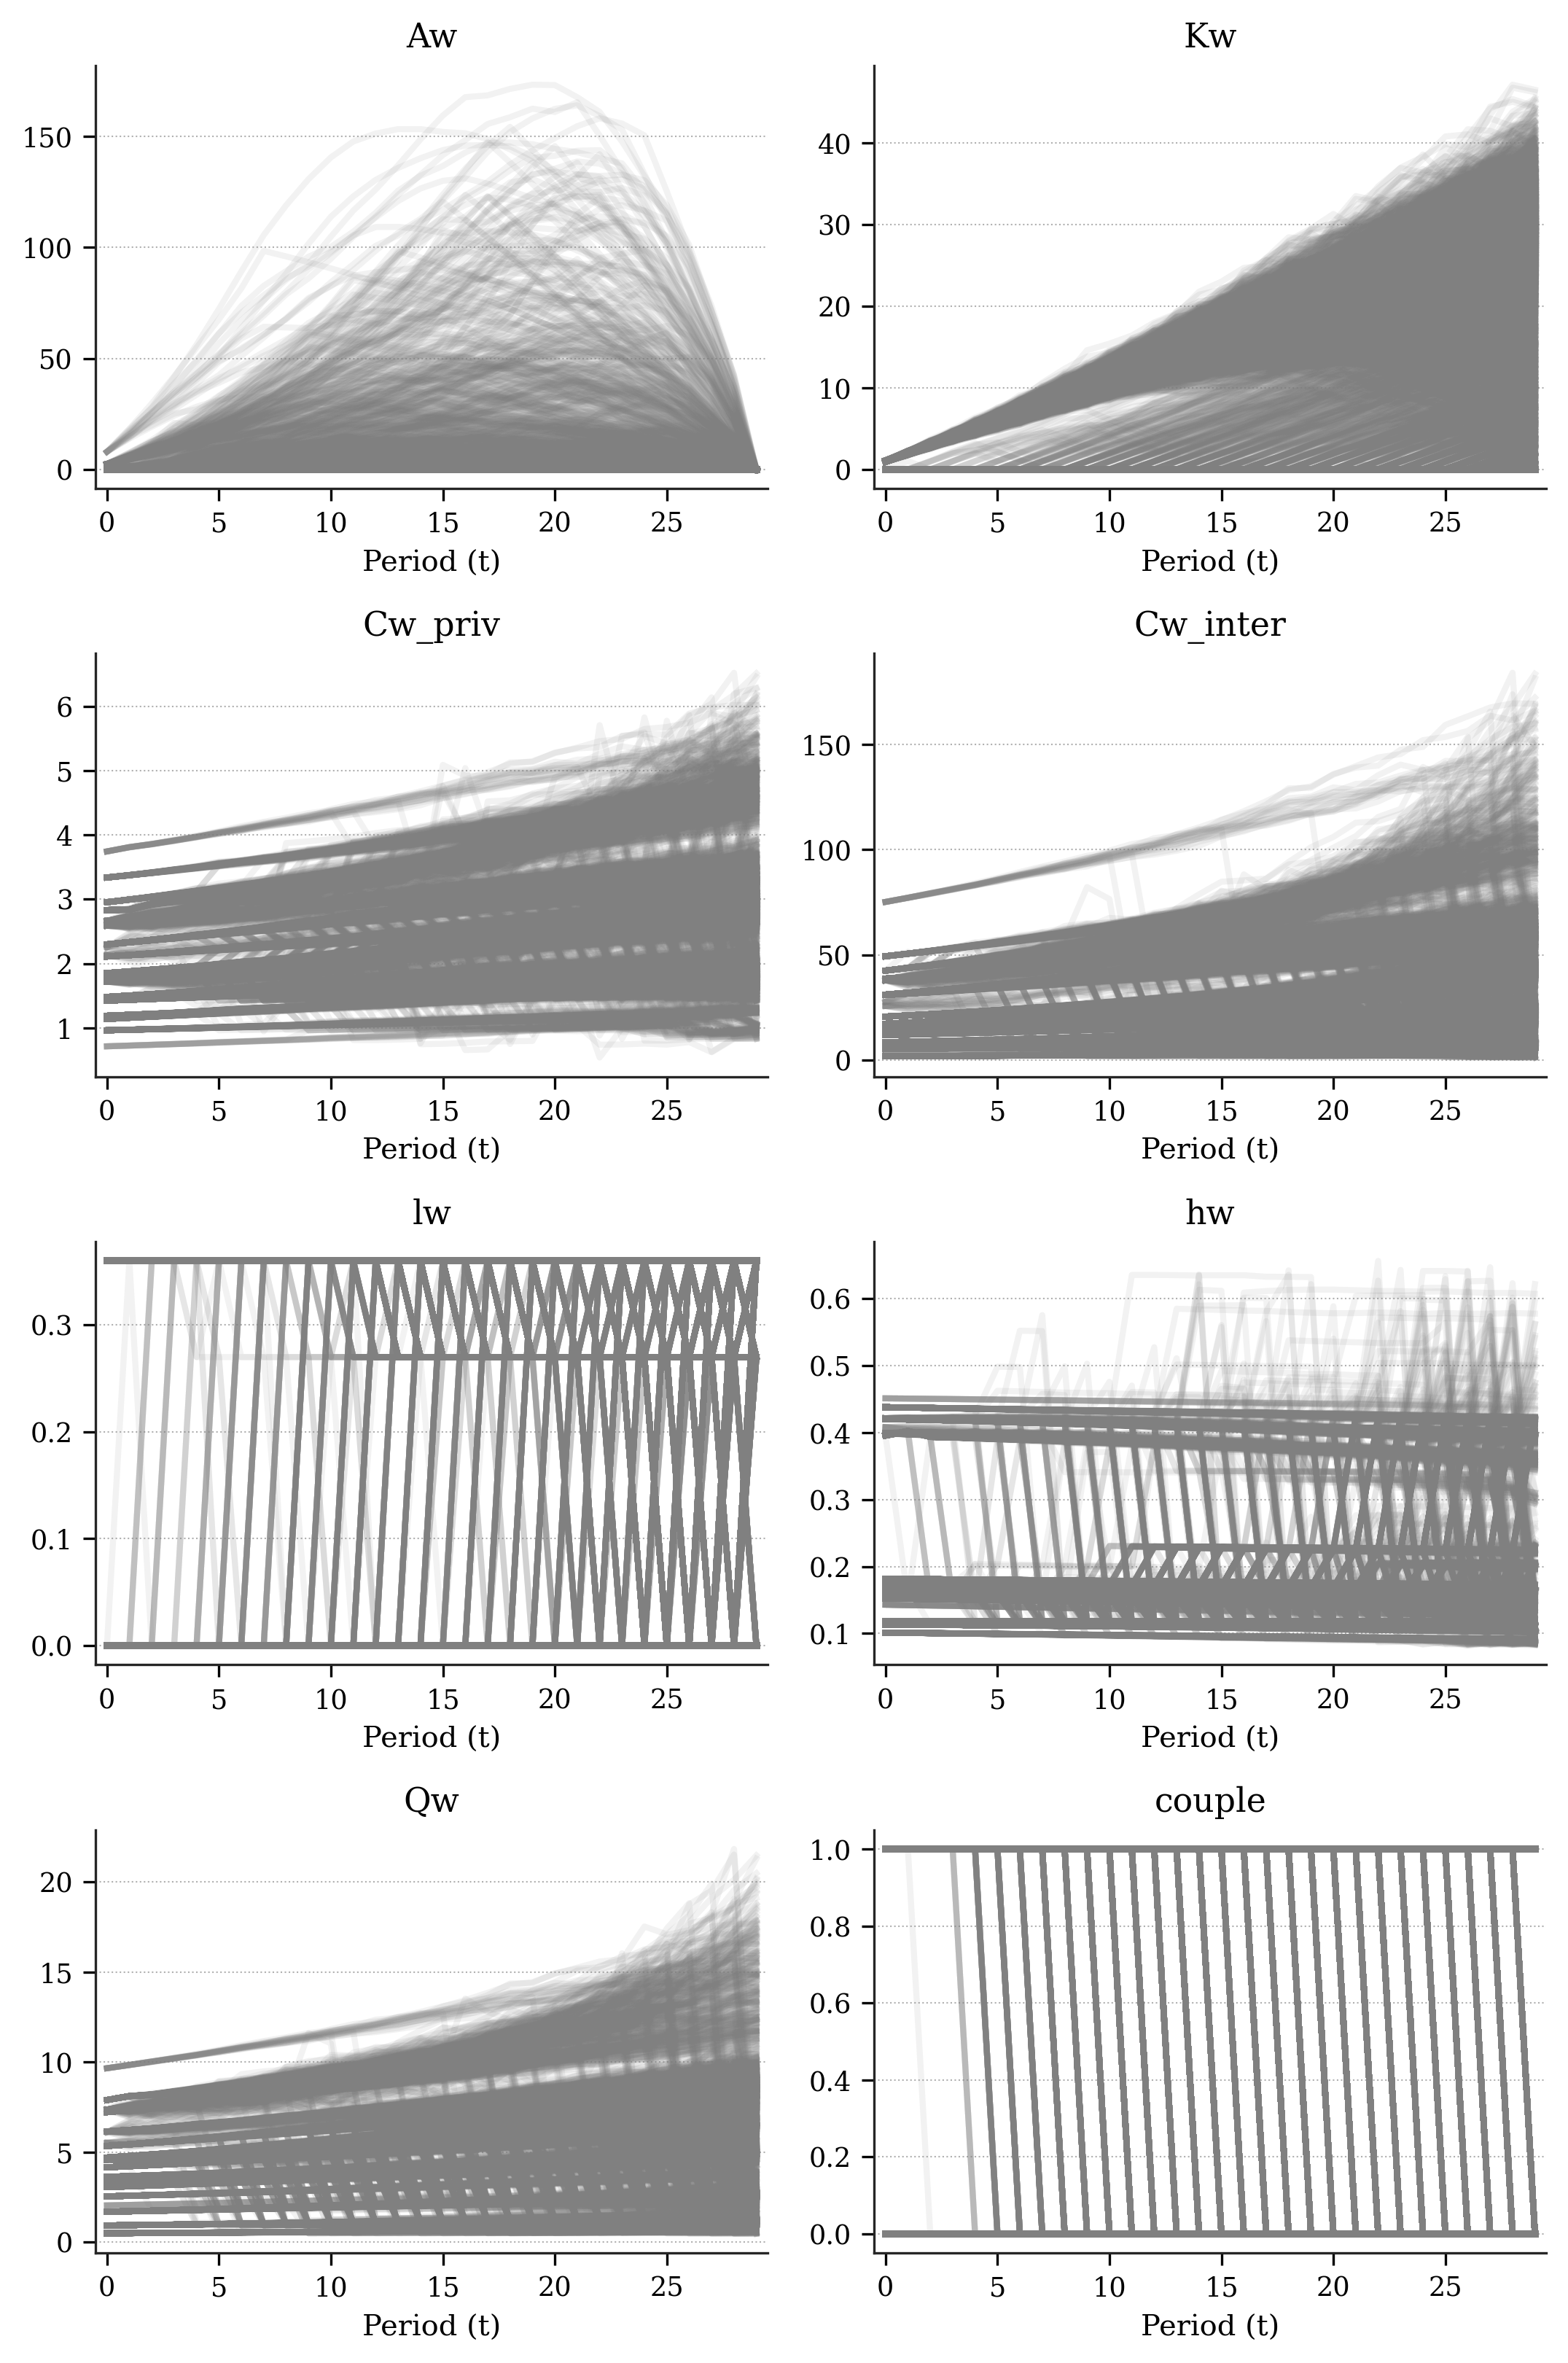

In [12]:
fig, ax = fm.create_figure(4,2,8)
mp.plot_sim_female(ax, agg_fct=None ,alpha=0.5)
fig.tight_layout()

## Estimate model

In [13]:
# DO_GLOBAL = True
# num_points = 5
# num_guess = 2

# if DO_GLOBAL:
#     theta_guesses = model.global_search(estpars, datamoms,weights,num_points,num_guess=num_guess,do_print=False)

#     for i in range(num_guess):
#         model.obj_func(theta_guesses[i],estpars, datamoms,weights, do_print=True)


In [ ]:
# Estimate model using nelder-mead algorithm
do_print = True # Turn off... 
res = minimize(model.obj_func, theta_init, args=(estpars, datamoms,weights,do_print), method='Nelder-Mead',
               options={'xatol': 1e-4, 'fatol': 1e-4, 'disp': True, 'maxiter':5000})


Parameters:
  sigma_k        : 0.0500 (init: 0.0500)
  phi_k          : 0.4000 (init: 0.4000)
Moments:
  wage_level_w_25_34       : sim: 41.4638, data: 40.1000
  wage_level_m_25_34       : sim: 52.1506, data: 49.3000
  wage_level_w_35_44       : sim: 52.9383, data: 50.4000
  wage_level_m_35_44       : sim: 69.2500, data: 67.8000
  employment_rate_w_35_44  : sim: 70.5896, data: 70.0000
  employment_rate_m_35_44  : sim: 97.6629, data: 85.0000
  work_hours_w             : sim: 40.2027, data: 32.1923
  work_hours_m             : sim: 40.3195, data: 39.6538
  consumption              : sim: 36.3337, data: 42.7160
  leisure_w                : sim: 58.2178, data: 60.0000
  leisure_m                : sim: 58.6975, data: 61.0000
  home_prod_w              : sim: 23.0598, data: 25.2000
  home_prod_m              : sim: 14.1408, data: 12.3000
Objective function value: 518.4429 (penalty: 0.0000, 217.4241)
-------------------------------------
Parameters:
  sigma_k        : 0.0525 (init: 0.0500)
  

In [ ]:
np.nanmean(model.sim.C_tot)

36.04721562856825